<a href="https://colab.research.google.com/github/Cralsic123/Detr-resnet50-metrics-comparison/blob/main/Detr_resnet50_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision
!pip install grad-cam
!git clone https://github.com/quic/ai-hub-models.git

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:

import torch
import torchvision.transforms as transforms
from torchvision import models
#from gradcam import GradCAM, show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


## DETR model


In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 232MB/s]


In [7]:
import zipfile
with zipfile.ZipFile('/content/brain-mri-images-for-brain-tumor-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./')


In [53]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")


In [54]:
image_path = '/content/brain_tumor_dataset/yes/Y1.jpg'
image = Image.open(image_path)

In [23]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

In [24]:
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]


In [25]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected cup with confidence 0.9 at location [18.09, 72.82, 90.13, 190.65]


In [ ]:
#model.eval()

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path)

    # Preprocess the image
    inputs = processor(images=image, return_tensors="pt")
    
    # Forward pass through the model
    outputs = model(**inputs)

    # Post-process the results
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

    # Print the results for the current image
    print(f"Results for {image_file}:")
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(
            f"  Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
        )
    print()

## Grad Cam visualization

In [34]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
#from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional

In [35]:
img_tensor = transforms.ToTensor()(image)

In [37]:

# We will show GradCAM for the "Egyptian Cat" and the 'Remote Control" categories:
# I changed it to cup because the model is detecting the anomaly in the brain as a cup
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "cup"))]

In [ ]:
#print(model)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [41]:
# target_layer = model.model.decoder.layernorm
classifier = model.class_labels_classifier

In [42]:
# The last layer in the Resnet Encoder:
#target_layer = model.encoder.stages[-1].layers[-1]
#target_layer = model.ResNetEncoder.stages[-1].layers[-1]
#target_layer = model.model.backbone.conv_encoder.model.encoder.stages[-1].layers[-1]
target_layer = [model.model.backbone.conv_encoder]


model.model.decoder.layernorm

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=None)))
print_top_categories(model, img_tensor)

AttributeError: 'list' object has no attribute 'register_forward_hook'

In [ ]:
# # Displaying DFF (Dimensionality Filter Framework) output
# dff_image = run_dff_on_image(
#     model=model,
#     target_layer=target_layer,
#     classifier=classifier,
#     img_pil=image,
#     img_tensor=img_tensor,
#     reshape_transform=None,
#     n_components=4,
#     top_k=2
# )
# display(Image.fromarray(dff_image))

# # Displaying Grad-CAM output
# grad_cam_image = run_grad_cam_on_image(
#     model=model,
#     target_layer=target_layer,
#     targets_for_gradcam=targets_for_gradcam,
#     reshape_transform=None
# )
# display(Image.fromarray(grad_cam_image))

In [28]:
def detr_reshape_transform(x):
    activations = x[:, 1:, :].reshape(x.size(0), 6, 6, x.size(2))
    activations = activations.permute(0, 3, 1, 2)
    return activations


In [30]:

target_layers = [model.model.backbone.conv_encoder]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available(), reshape_transform=detr_reshape_transform)
targets = [ClassifierOutputTarget(label.item()) for label in results["labels"]]
grayscale_cam = cam(input_tensor=inputs["pixel_values"], targets=targets)
grayscale_cam = grayscale_cam[0, :]
rgb_img = np.float32(image) / 255
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.axis('off')
plt.show()


Exception ignored in: <function BaseCAM.__del__ at 0x7972793053f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytorch_grad_cam/base_cam.py", line 196, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


TypeError: GradCAM.__init__() got an unexpected keyword argument 'use_cuda'

In [31]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Target the last convolutional layer of the backbone
target_layers = [model.model.backbone.conv_encoder]

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=detr_reshape_transform)

# Generate the activation map
targets = [ClassifierOutputTarget(label.item()) for label in results["labels"]]
grayscale_cam = cam(input_tensor=inputs["pixel_values"], targets=targets)

# Convert grayscale CAM to RGB
grayscale_cam = grayscale_cam[0, :]
rgb_img = np.float32(image) / 255
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display the result
plt.imshow(visualization)
plt.axis('off')
plt.show()


TypeError: list indices must be integers or slices, not tuple

## Just a different view


In [43]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

In [46]:
def reshape_transform_vit_huggingface(x):
    # Remove the CLS token:
    activations = x[:, 1:, :]
    # Reshape to a 12 x 12 spatial image:
    activations = activations.view(activations.shape[0], 12, 12, activations.shape[2])
    # Transpose the features to be in the second coordinate:
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

In [47]:
def segformer_reshape_transform_huggingface(tensor, width, height):
    result = tensor.reshape(tensor.size(0),
                            height,
                            width,
                            tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

reshape_transform = partial(segformer_reshape_transform_huggingface,
                            width=img_tensor.shape[2]//32,
                            height=img_tensor.shape[1]//32)

NameError: name 'partial' is not defined

In [49]:
def reshape_transform_cvt_huggingface(tensor, model, width, height):
    tensor = tensor[:, 1 :, :]
    tensor = tensor.reshape(tensor.size(0),
                            height,
                            width,
                            tensor.size(-1))
    norm = model.layernorm(tensor)
    return norm.transpose(2, 3).transpose(1, 2)

In [50]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
#from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional
image_path = '/content/brain_tumor_dataset/yes/Y1.jpg'
image = Image.open(image_path)
img_tensor = transforms.ToTensor()(image)

""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]

""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.

"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module=img_tensor,
                          input_image: Image=image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)


def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

Exception ignored in: <function DeepFeatureFactorization.__del__ at 0x797278536290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytorch_grad_cam/feature_factorization/deep_feature_factorization.py", line 87, in __del__
AttributeError: 'DeepFeatureFactorization' object has no attribute 'activations_and_grads'


In [65]:
from transformers import ResNetForImageClassification
model2 = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")


In [66]:
model2

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [68]:
model


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

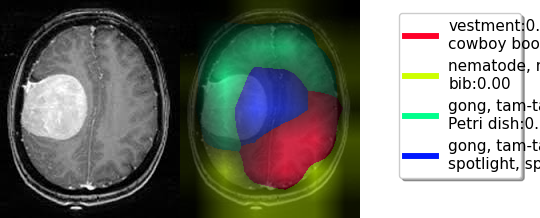

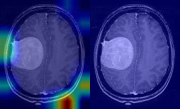

Predicted class 577: gong, tam-tam
Predicted class 111: nematode, nematode worm, roundworm
Predicted class 712: Petri dish
Predicted class 818: spotlight, spot
Predicted class 494: chime, bell, gong


In [79]:
# We will show GradCAM for the "Egyptian Cat" and the 'Remote Control" categories:
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model2, "cup")),
                       ClassifierOutputTarget(category_name_to_index(model2, "remote control, remote"))]

# The last layer in the Resnet Encoder:
target_layer = model2.resnet.encoder.stages[-1].layers[-1]

display(Image.fromarray(run_dff_on_image(model=model2,
                          target_layer=target_layer,
                          classifier=model2.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model2,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=None)))
print_top_categories(model2, img_tensor)

In [80]:
# We will show GradCAM for the "Egyptian Cat" and the 'Remote Control" categories:
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "cup"))]
#The last layer in the Resnet Encoder:
#target_layers = [model.model.backbone.conv_encoder]
target_layers = model.model.backbone.conv_encoder.model.encoder.stages[-1].layers[-1]

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layers,
                          classifier=model.class_labels_classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layers,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=None)))
print_top_categories(model, img_tensor)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x2048 and 256x92)

The error RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x2048 and 256x92) indicates that there's a mismatch between the shapes of the matrices being multiplied, likely due to the wrong layer being used as target_layer. The layernorm layer has an output of shape (batch_size, sequence_length, 256), which is not directly compatible with the classifier expecting an input of shape (batch_size, 256).

To solve this, we should use the correct layer's output, which matches the input expected by the classifier. The target_layer should be the last layer in the decoder before the classifier. In the DETR model, this is typically the output of the decoder.